# **_Aplicación de Machine Learning para la Optimización del Portafolio Gastronómico de una cadena de restaurantes_**

# 1. Contexto del Problema

La empresa analizada es una cadena de restaurantes con un portafolio extremadamente amplio (alrededor de **200 productos** entre platos, bebidas y variantes). Esta magnitud dificulta identificar, de forma sistemática, qué ítems deben mantenerse en la carta, cuáles deberían eliminarse o rediseñarse y cuáles representan oportunidades estratégicas para mejorar la rentabilidad.

En gastronomía se emplean herramientas tradicionales la **ingeniería del menú**, que clasifican productos principalmente según dos variables: **rotación** y **margen**. Sin embargo, estos métodos dependen de cortes manuales, reglas simples o comparaciones contra promedios, lo cual resulta insuficiente cuando el portafolio es grande y diverso.

Estas metodologías no capturan dimensiones clave como la **complejidad operativa** (como la cantidad de insumos por producto), la **variabilidad real de costos**, la **frecuencia de pedido**, ni los **patrones multivariados** entre productos. En portafolios con cientos de ítems, estos enfoques pueden ocultar productos ineficientes, generar agrupaciones poco precisas y llevar a decisiones sesgadas.

Ante esta limitación, se propone un enfoque basado en técnicas de **Machine Learning**, especialmente reducción de dimensionalidad y **clustering no supervisado**, que permita analizar simultáneamente múltiples dimensiones del desempeño de cada producto y descubrir **grupos naturales** que no son detectables con metodologías tradicionales.


# 2.Diccionario de datos

A continuación, se presenta un resumen estructurado de las variables disponibles:

| Variable            | Tipo        | Descripción |
|--------------------|-------------|-------------|
| `codigo_producto`  | Categórica  | Identificador único del producto en el sistema. |
| `item_nombre`      | Categórica  | Nombre comercial del producto. |
| `frecuencia_venta` | Numérica    | Proporción de días del trimestre en los que el producto tuvo al menos una venta. |
| `promedio_diario`  | Numérica    | Promedio diario de unidades vendidas. |
| `unidades_totales` | Numérica    | Cantidad total de unidades vendidas durante el trimestre. |
| `precio_carta`     | Numérica    | Precio de venta del producto según la carta. |
| `costos`           | Numérica    | Costo total de producción del ítem (incluye insumos). |
| `q_insumos`        | Numérica    | Número de insumos utilizados en la preparación del producto (proxy de complejidad operativa). |
| `margen`           | Numérica    | Margen de contribución del producto expresado en porcentaje. |
| `categoria`        | Categórica  | Categoría general del producto (ej.: bebidas, fondos, entradas, etc.). |

# 3. Objetivos

El objetivo de la estrategia es construir una **segmentación cuantitativa del portafolio**, basada en modelos de Machine Learning, que permita identificar grupos de productos con comportamientos similares en términos de **margen**, **volumen de ventas** y **complejidad operativa**.

Con esta segmentación, la empresa podrá reconocer:
- Qué productos aportan poco a la rentabilidad.
- Cuáles funcionan como artículos **gancho** de alta rotación.
- Cuáles exigen un esfuerzo operativo desproporcionado.
- Cuáles son candidatos a **mantener**, **ajustar** o **retirar**.

La estrategia no busca modificar directamente la rentabilidad, sino proporcionar a la empresa una **base analítica sólida** para tomar decisiones informadas sobre la optimización de su carta y la gestión estratégica de su portafolio de productos.

# 3. Análisis Exploratorio de Datos (EDA)

Para este análisis se dispone de información histórica correspondiente a **un trimestre de ventas** de una tienda de la cadena.
El objetivo del EDA es comprender la estructura del portafolio, evaluar la distribución del margen y la rotación, detectar outliers relevantes y preparar el dataset para los métodos de clustering.

El dataset contiene variables categóricas y numéricas que describen el desempeño y la complejidad operativa de cada producto.

In [5]:
import pandas as pd

In [6]:
df_tienda = pd.read_csv("ventas_tiendas_tumbes.csv")
round(df_tienda.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
codigo_producto,213.0,1605696.86,586295.33,1000001.00,1000062.00,2000013.00,2000083.00,3000068.00
frecuencia_venta,213.0,0.52,0.34,0.03,0.19,0.48,0.84,1.00
promedio_diario,213.0,3.06,6.81,0.03,0.23,0.97,2.26,57.36
unidades_totales,213.0,94.75,211.09,1.00,7.00,30.00,70.00,1778.00
precio_carta,213.0,33.68,26.96,0.00,15.00,26.00,43.00,148.00
costos,213.0,10.65,11.56,0.12,2.65,7.10,13.61,70.46
q_insumos,213.0,6.40,4.48,1.00,2.00,6.00,9.00,21.00
margen,213.0,23.03,16.87,-7.47,10.88,20.32,30.70,87.53


In [8]:
print(df_tienda.describe().T.round(2))

                  count        mean        std         min         25%  \
codigo_producto   213.0  1605696.86  586295.33  1000001.00  1000062.00   
frecuencia_venta  213.0        0.52       0.34        0.03        0.19   
promedio_diario   213.0        3.06       6.81        0.03        0.23   
unidades_totales  213.0       94.75     211.09        1.00        7.00   
precio_carta      213.0       33.68      26.96        0.00       15.00   
costos            213.0       10.65      11.56        0.12        2.65   
q_insumos         213.0        6.40       4.48        1.00        2.00   
margen            213.0       23.03      16.87       -7.47       10.88   

                         50%         75%         max  
codigo_producto   2000013.00  2000083.00  3000068.00  
frecuencia_venta        0.48        0.84        1.00  
promedio_diario         0.97        2.26       57.36  
unidades_totales       30.00       70.00     1778.00  
precio_carta           26.00       43.00      148.00  
cos

Los estadísticos descriptivos muestran una marcada heterogeneidad entre productos. La frecuencia de venta es, en promedio, **0.52 veces por día**, pero con **alta dispersión** (std 0.34), lo que revela productos muy vendidos conviviendo con otros de rotación mínima. Los precios exhiben una variación considerable —van desde **S/0 hasta S/148**—, lo que confirma un portafolio amplio en niveles de valor percibido. Asimismo, el número de insumos por producto presenta una mediana de **6 insumos**, evidenciando diferencias importantes en complejidad operativa. Finalmente, el margen muestra valores que van desde **márgenes negativos (-7.47)** hasta productos con **márgenes muy altos (87.53)**, sugiriendo posibles ineficiencias y oportunidades de optimización dentro del menú.

## 3.1 Matriz de Correlación

La matriz de correlación evidencia tres hallazgos centrales. Primero, la **frecuencia de venta, el promedio diario y las unidades totales están altamente correlacionadas**, mostrando que la popularidad de un producto es consistente entre métricas. Segundo, **precio de carta y costos presentan una correlación muy alta (0.92)**, lo que confirma que los productos más caros también son los que más cuestan operar; sin embargo, el **margen unitario no depende de la popularidad**, sino de la relación precio–costo. Finalmente, la **cantidad de insumos muestra correlaciones bajas o moderadas**, indicando que la complejidad operativa es una dimensión independiente que no puede inferirse directamente de las ventas o márgenes y que debe analizarse aparte dentro del modelo de optimización del portafolio.

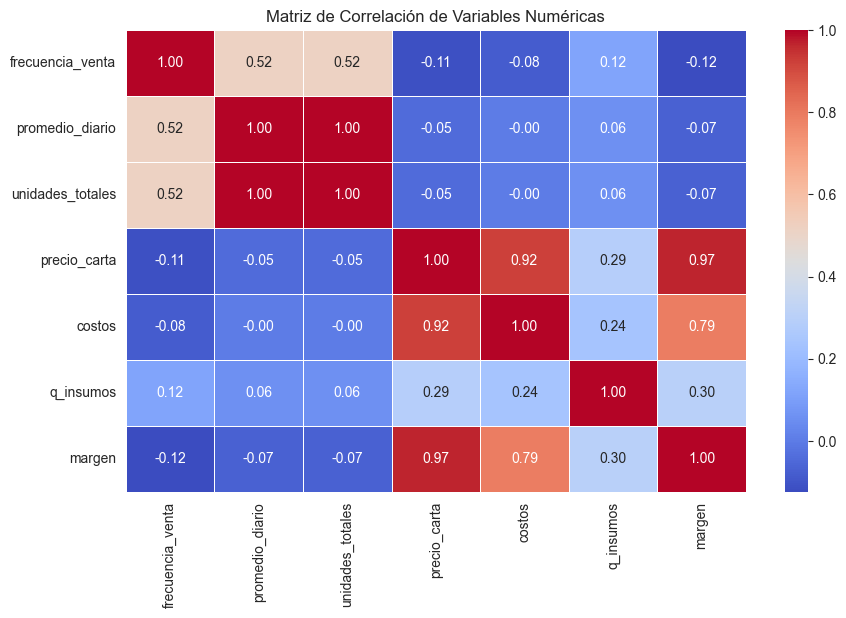

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionamos solo las columnas numéricas (quitando código y nombre)
corr = df_tienda.drop(["codigo_producto", "item_nombre","categoria"], axis=1).corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()

## 3.2 Distribución del margen por categoría general
Para identificar qué categorías aportan más al margen total, se construyó un gráfico de Pareto que combina el margen total por categoría y su porcentaje acumulado. Este análisis permite visualizar rápidamente qué categorías concentran la mayor contribución económica y cuáles tienen un impacto marginal. La línea del 80% sirve como referencia clásica para distinguir las “categorías vitales” que impulsan la mayor parte de la rentabilidad del menú.

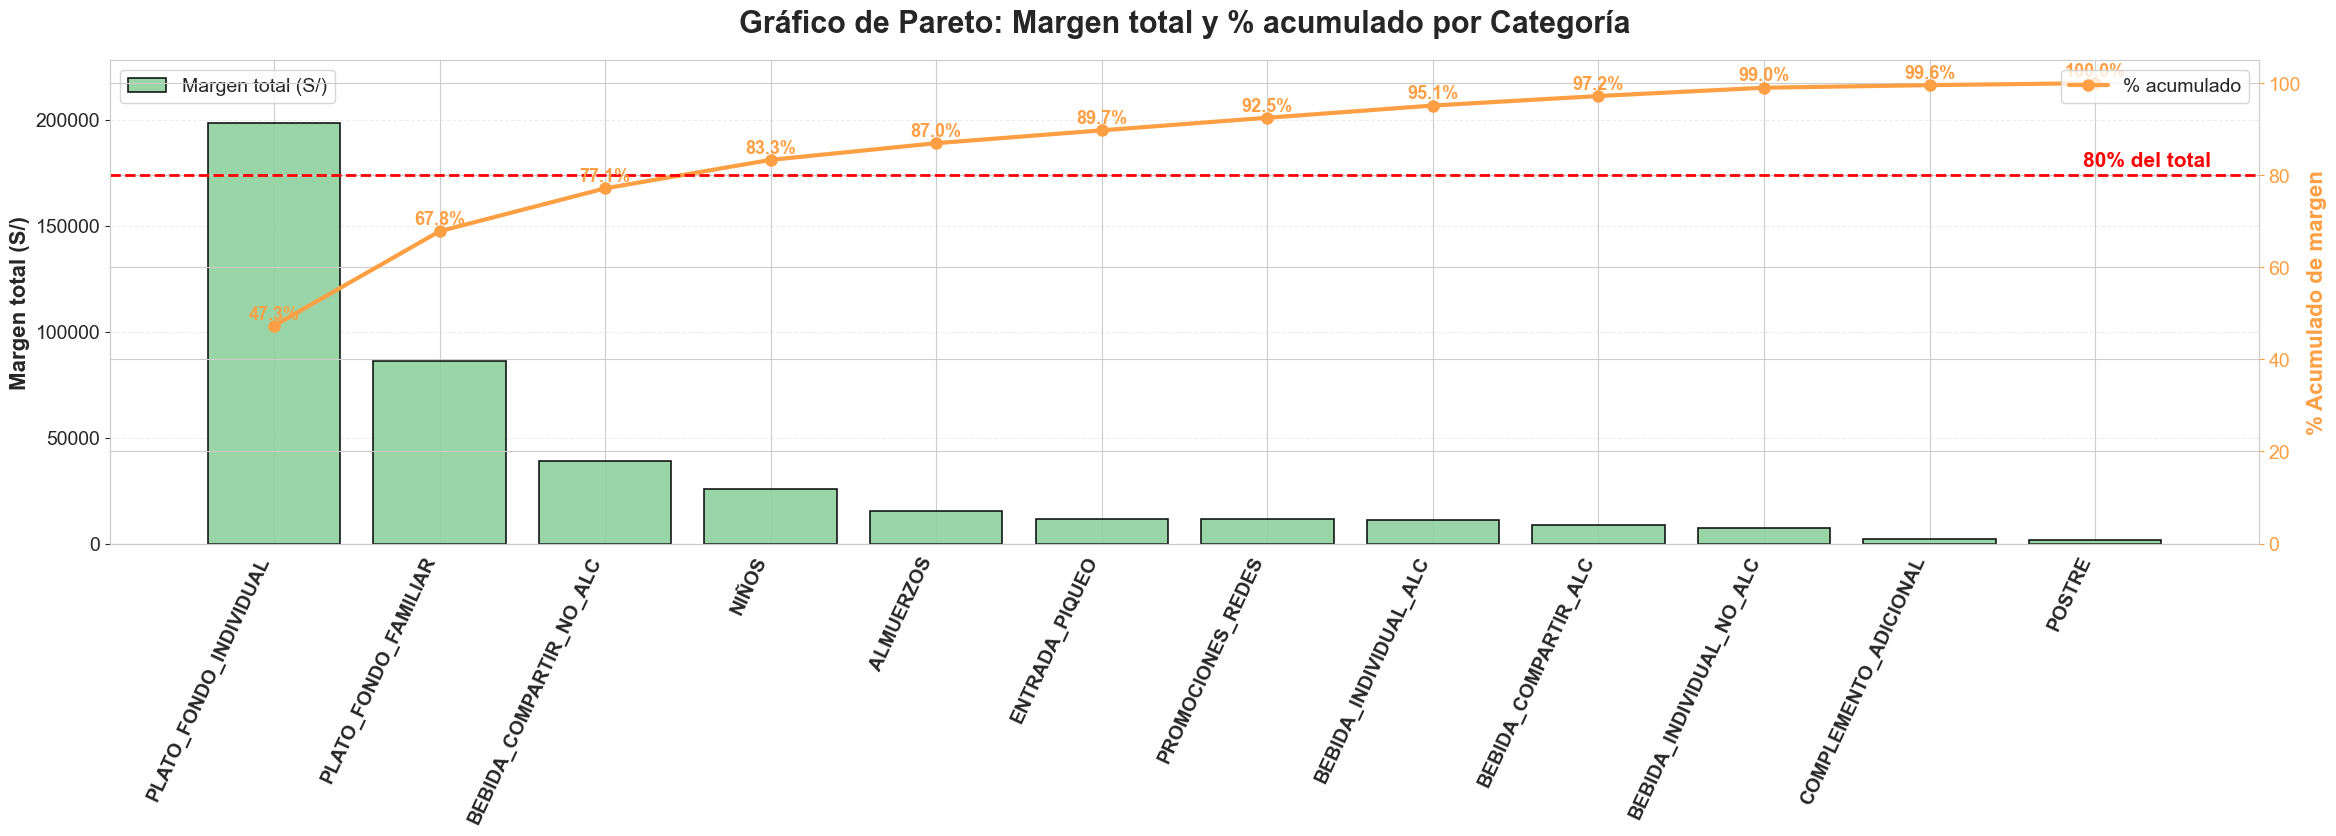

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# ===========================================================
# 1) Calcular margen total por categoría
# ===========================================================
df_tienda["margen_total"] = df_tienda["margen"] * df_tienda["unidades_totales"]

# Agrupar por categoría
pareto = (
    df_tienda.groupby("categoria")["margen_total"]
    .sum()
    .sort_values(ascending=False)
    .to_frame()
)

# Solo categorías con margen total positivo para el Pareto
pareto = pareto[pareto["margen_total"] > 0]

# Recalcular acumulado y porcentaje
pareto["acum"] = pareto["margen_total"].cumsum()
pareto["acum_pct"] = 100 * pareto["acum"] / pareto["margen_total"].sum()

# Para evitar que el último quede en 99.999… por redondeos, lo fijamos a 100
pareto.iloc[-1, pareto.columns.get_loc("acum_pct")] = 100.0

# ===========================================================
# 2) Gráfico de Pareto mejorado
# ===========================================================
fig, ax1 = plt.subplots(figsize=(24, 9))

# --- Barras de margen total -------------------------------
bars = ax1.bar(
    pareto.index,
    pareto["margen_total"],
    color="#8fd19e",
    alpha=0.9,
    edgecolor="black",
    linewidth=1.2,
    label="Margen total (S/)"
)

# Eje Y principal
ax1.set_ylabel("Margen total (S/)", fontsize=16, fontweight="bold")
ax1.tick_params(axis='y', labelsize=14)

# Dar aire en la parte superior del eje Y
y_max = pareto["margen_total"].max()
ax1.set_ylim(0, y_max * 1.15)

# Eje X (categorías)
ax1.set_xticklabels(
    pareto.index,
    rotation=65,
    ha='right',
    fontsize=14,
    fontweight="bold"
)

ax1.grid(axis='y', linestyle='--', alpha=0.35)

# --- Línea del % acumulado -------------------------------
ax2 = ax1.twinx()
ax2.plot(
    pareto.index,
    pareto["acum_pct"],
    color="#ff9f43",
    marker="o",
    markersize=8,
    linewidth=3,
    label="% acumulado"
)

ax2.set_ylabel("% Acumulado de margen", fontsize=16, fontweight="bold", color="#ff9f43")
ax2.set_ylim(0, 105)  # un poco de aire arriba
ax2.tick_params(axis='y', labelsize=14, colors="#ff9f43")

# Etiquetas numéricas sobre la línea
for i, pct in enumerate(pareto["acum_pct"]):
    ax2.text(
        i,
        pct + 1.5,
        f"{pct:.1f}%",
        color="#ff9f43",
        fontsize=13,
        fontweight="bold",
        ha='center'
    )

# Línea de referencia del 80 %
ax2.axhline(80, color="red", linestyle="--", linewidth=2)
ax2.text(
    len(pareto) - 0.3,
    82,
    "80% del total",
    color="red",
    fontsize=15,
    fontweight="bold",
    ha="right"
)

# Título
plt.title(
    "Gráfico de Pareto: Margen total y % acumulado por Categoría",
    fontsize=22,
    fontweight="bold",
    pad=20
)

# Leyendas
ax1.legend(loc="upper left", fontsize=14)
ax2.legend(loc="upper right", fontsize=14)

plt.tight_layout(pad=3)
plt.show()

El gráfico de Pareto muestra una fuerte concentración del margen en pocas categorías: **PLATO_FONDO_INDIVIDUAL**, **PLATO_FONDO_FAMILIAR** y **BEBIDA_COMPARTIR_NO_ALC** generan cerca del **80% del margen total**.

El resto de categorías aporta montos significativamente menores, lo que confirma un portafolio con **alta dependencia de un conjunto reducido de productos clave**. Este hallazgo respalda la necesidad de un análisis más profundo mediante técnicas de clustering para identificar patrones de rentabilidad, complejidad y rotación a nivel de producto, y así orientar decisiones de optimización del menú.

## 3.3 Cantidad de productos por categorías

El contraste entre ambos gráficos revela patrones importantes para la optimización del portafolio:

- Las categorías **más pobladas**, como **PLATO_FONDO_INDIVIDUAL** y **BEBIDA_INDIVIDUAL_ALC**, reúnen cerca de cien productos en conjunto. Si bien generan una parte relevante del margen total, lo hacen de manera **muy heterogénea**, lo que indica que existen numerosos productos con bajo aporte dentro de estas categorías. Estas son, por tanto, las principales candidatas para una **reducción del portafolio** o una revisión más fina de su composición.

- Por el contrario, categorías con **muy pocos productos** —como **PLATO_FONDO_FAMILIAR**, **POSTRE**, **NIÑOS** o **ALMUERZOS**— muestran un aporte de margen **elevado en relación a su tamaño**. Esto refleja una oferta eficiente y concentrada, donde **no es necesario aplicar recortes**, ya que cada producto cumple un rol significativo.

- En conjunto, el análisis sugiere que los esfuerzos de optimización deben orientarse hacia **categorías grandes con bajo desempeño promedio**, mientras que las categorías pequeñas con buen rendimiento deben **conservarse y monitorearse**, evitando reducciones que podrían afectar la propuesta de valor actual.

Este enfoque permite priorizar decisiones basadas en evidencia y maximizar el impacto en la rentabilidad del menú.

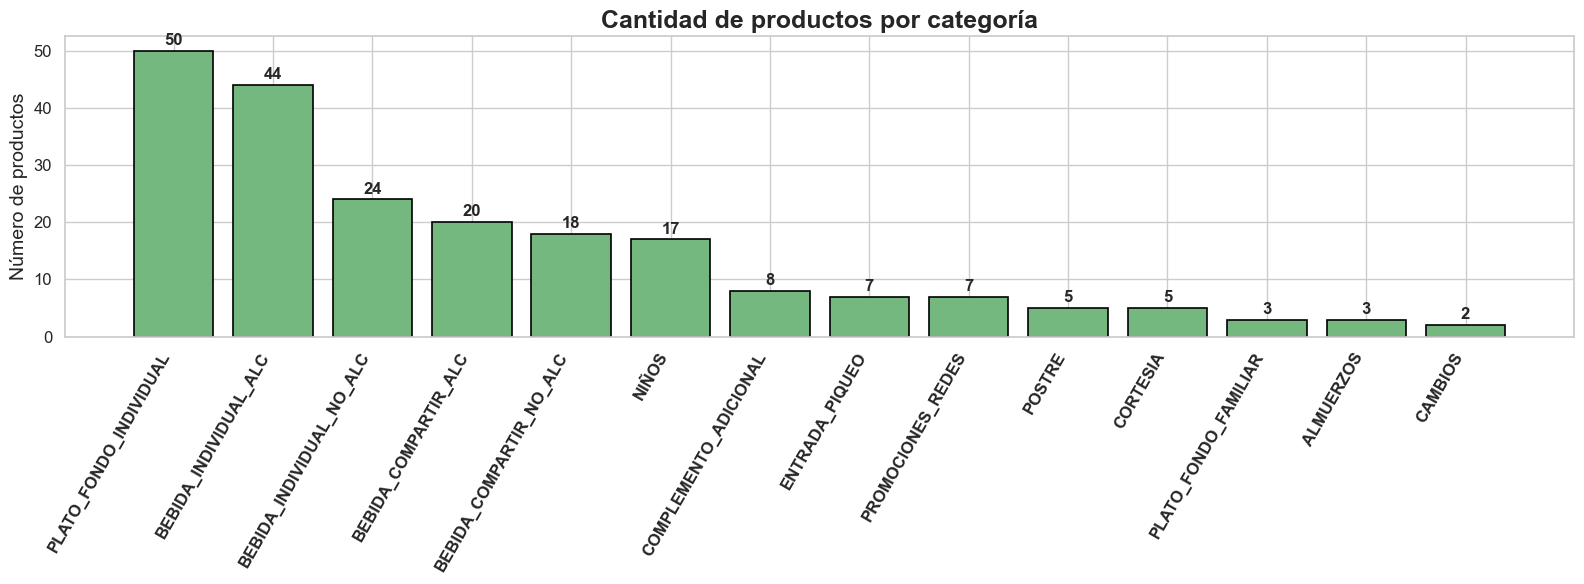

In [8]:
# ================================
# 3.3 Cantidad de productos por categoría
# ================================

import matplotlib.pyplot as plt
import seaborn as sns

# Contar productos por categoría
cat_counts = df_tienda['categoria'].value_counts().sort_values(ascending=False)

# Estilo visual
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))

# Gráfico de barras
bars = plt.bar(
    cat_counts.index,
    cat_counts.values,
    color="#74b77f",
    edgecolor="black",
    linewidth=1.2
)

# Títulos y etiquetas
plt.title("Cantidad de productos por categoría", fontsize=18, fontweight="bold")
plt.ylabel("Número de productos", fontsize=14)
plt.xticks(rotation=60, ha='right', fontsize=12, fontweight="bold")
plt.yticks(fontsize=12)

# Mostrar valores encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.5,
        f"{int(height)}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

## 3.4 Análisis de outliers relevantes de precio, margen, insumos

El análisis de outliers revela patrones importantes para entender la estructura del portafolio:

- **Precio de carta:** existen productos con precios significativamente mayores al resto del menú. Estos ítems suelen pertenecer a categorías premium o familiares, y aunque no distorsionan de forma negativa la estrategia, sí requieren verificación de coherencia con su costo y demanda.

- **Margen:** se observan productos con márgenes excepcionalmente altos, lo que sugiere oportunidades de promoción o priorización comercial. También aparecen algunos márgenes negativos que indican errores de costeo o posibles ineficiencias de operación.

- **Costos:** los costos presentan variabilidad moderada, aunque algunos productos tienen costos extremadamente altos. Estos casos deben revisarse porque pueden comprometer la rentabilidad total de la categoría si su rotación es baja.

- **Cantidad de insumos:** se identifican productos con **más de 15 ingredientes**, lo que implica una alta complejidad operativa. Estos items son candidatos naturales para simplificación o eliminación, pues incrementan tiempos, errores y costos indirectos.

En conjunto, los outliers encontrados no solo representan excepciones estadísticas, sino también **puntos críticos que pueden impactar la rentabilidad o la eficiencia operativa**. Su revisión es clave para una posterior optimización del portafolio.

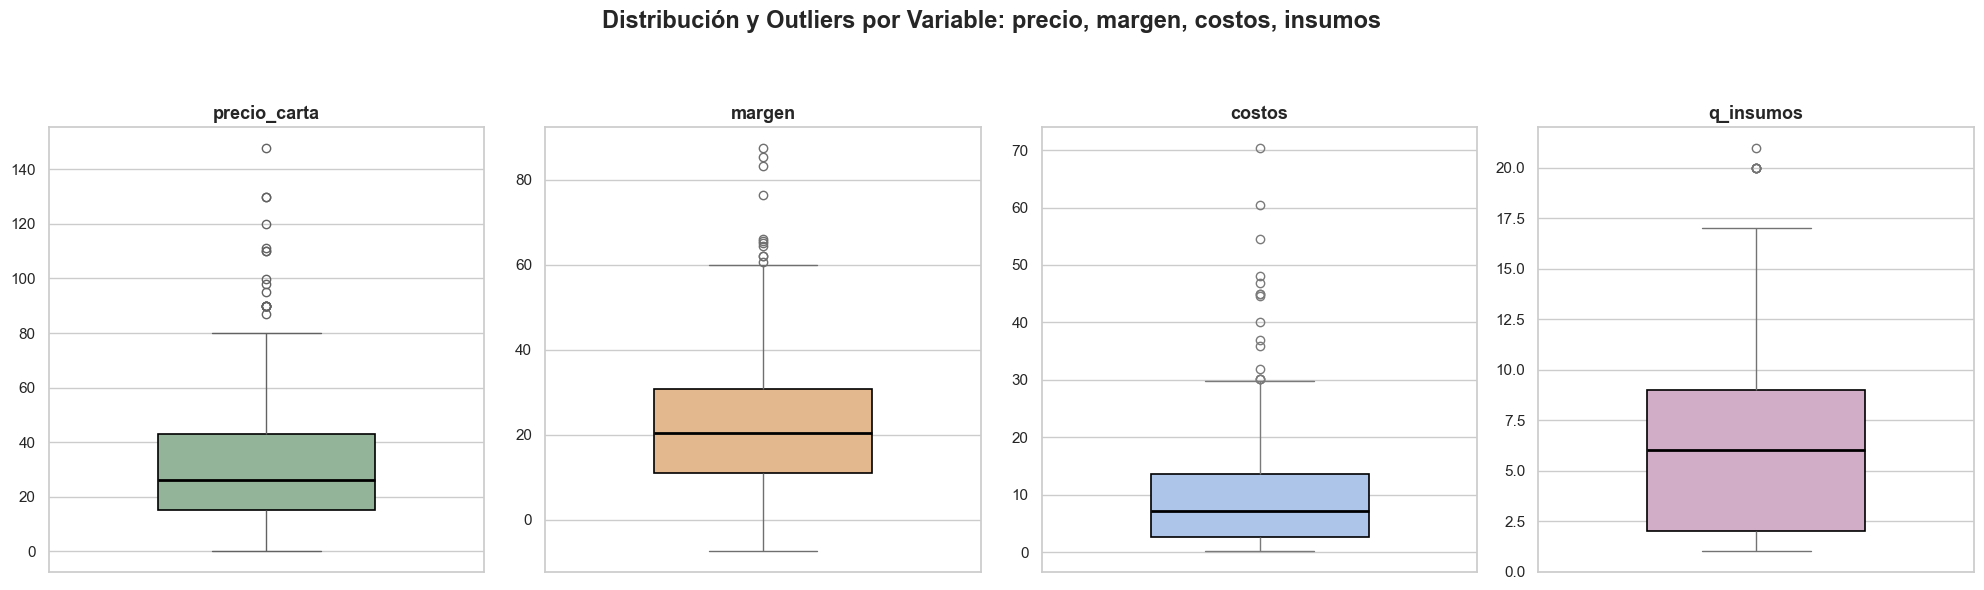

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables numéricas donde queremos identificar outliers
vars_outliers = ['precio_carta', 'margen', 'costos', 'q_insumos']

# Nueva paleta suave y diferenciada
palette = ["#8FB996", "#F2B880", "#A4C2F4", "#D8A7CA"]

plt.figure(figsize=(20, 6))
sns.set_style("whitegrid")

for i, (var, color) in enumerate(zip(vars_outliers, palette), 1):
    plt.subplot(1, 4, i)
    sns.boxplot(
        data=df_tienda,
        y=var,
        color=color,
        width=0.5,
        boxprops=dict(edgecolor="black", linewidth=1.2),
        medianprops=dict(color="black", linewidth=2)
    )
    plt.title(var, fontsize=13, fontweight='bold')
    plt.ylabel('')
    plt.xlabel('')

plt.suptitle("Distribución y Outliers por Variable: precio, margen, costos, insumos",
             fontsize=17, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

## 3.5 Matriz de Ingeniería del Menú por Categorías Clave

En cada matriz de Ingeniería del Menú se representan los productos de una categoría según dos dimensiones:

- **Eje X – Frecuencia de venta**: proporción de días en los que el producto se vendió al menos una vez.
- **Eje Y – Margen unitario (S/)**: margen promedio por unidad vendida.

Las líneas punteadas dividen el plano en cuatro cuadrantes:

- **Alta frecuencia y alto margen**: productos “estrella”, que deberían protegerse y reforzarse (no conviene retirarlos; se pueden usar como ancla del portafolio).
- **Alta frecuencia y bajo margen**: productos “gancho”, útiles para atraer volumen; pueden requerir revisión de precios, costos o tamaños de porción.
- **Baja frecuencia y alto margen**: productos “nicho” o “premium”, que podrían impulsarse con promociones específicas, cambios de visibilidad en la carta o bundles.
- **Baja frecuencia y bajo margen**: productos de baja contribución, que son candidatos naturales para **ser reemplazados, rediseñados o retirados** del portafolio.

In [10]:
import matplotlib.pyplot as plt

def plot_menu_engineering(
    df,
    categoria_objetivo,
    col_categoria='categoria',
    col_freq='frecuencia_venta',
    col_margen='margen',
    col_nombre='item_nombre',
    titulo_prefix='Matriz de Ingeniería del Menú'
):
    """
    Grafica la matriz de Ingeniería del Menú para una categoría específica.
    - Eje X: frecuencia de venta (0–1)
    - Eje Y: margen unitario
    Dibuja líneas de corte en la media de frecuencia y de margen.
    """

    # Filtrar datos de la categoría
    d = df[df[col_categoria] == categoria_objetivo].copy()

    if d.empty:
        print(f"No hay datos para la categoría: {categoria_objetivo}")
        return

    x = d[col_freq].astype(float)
    y = d[col_margen].astype(float)
    nombres = d[col_nombre].astype(str)

    # Medias
    x_mean = x.mean()
    y_mean = y.mean()

    # Rangos y padding para que no se corten etiquetas
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    x_pad = 0.08 * (x_max - x_min if x_max > x_min else 1)
    y_pad = 0.08 * (y_max - y_min if y_max > y_min else 1)

    fig, ax = plt.subplots(figsize=(10, 7))

    # Dispersión
    ax.scatter(
        x,
        y,
        s=45,
        color='#1f77b4',
        edgecolor='black',
        alpha=0.8
    )

    # Líneas de corte
    ax.axvline(x_mean, color='darkorange', linestyle='--', linewidth=1.7)
    ax.axhline(y_mean, color='darkorange', linestyle='--', linewidth=1.7)

    # Etiquetas de puntos, con pequeño desplazamiento
    for xi, yi, nombre in zip(x, y, nombres):
        ax.annotate(
            nombre,
            (xi, yi),
            xytext=(3, 3),
            textcoords='offset points',
            fontsize=7,
            fontweight='bold',
            ha='left',
            va='bottom'
        )

    # Límites con padding
    ax.set_xlim(x_min - x_pad, x_max + x_pad)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)

    # Títulos y ejes
    ax.set_title(
        f"{titulo_prefix} - {categoria_objetivo}",
        fontsize=14,
        fontweight='bold',
        pad=15
    )
    ax.set_xlabel("Frecuencia de venta", fontsize=12)
    ax.set_ylabel("Margen unitario (S/)", fontsize=12)

    # Grid suave
    ax.grid(True, linestyle='--', alpha=0.25)

    plt.tight_layout()
    plt.show()

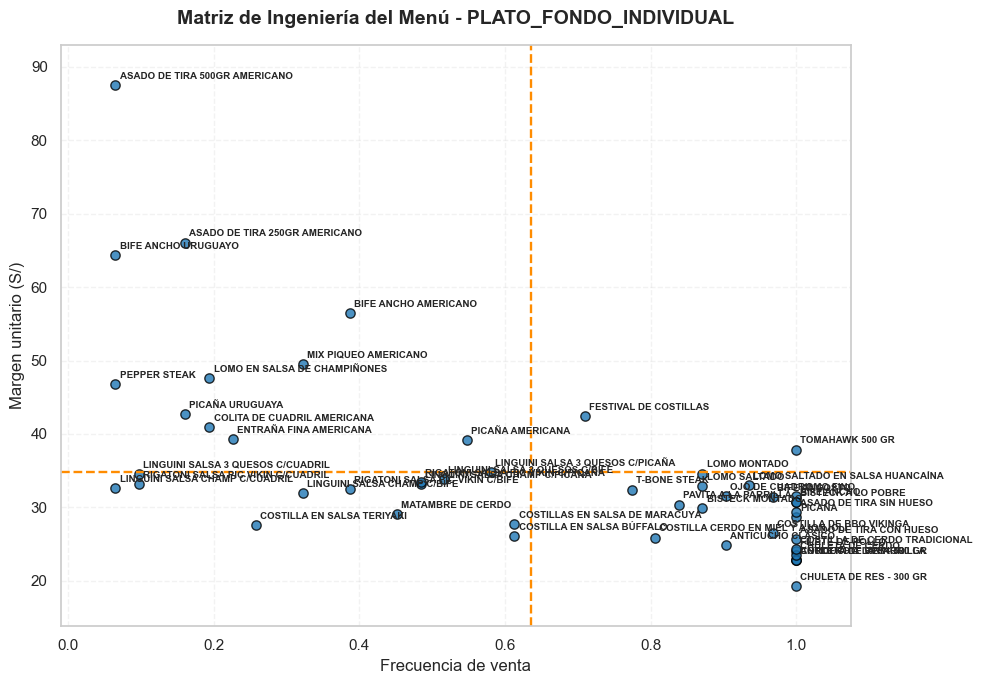

In [11]:
plot_menu_engineering(df_tienda, 'PLATO_FONDO_INDIVIDUAL')

La matriz revela una **alta dispersión entre los platos de fondo individuales**, evidenciando que esta categoría está sobrepoblada y presenta desempeños muy heterogéneos. Destacan productos como **Festival de Costillas** y **Tomahawk 500 gr**, ubicados claramente en la zona de **alto margen y alta frecuencia**, consolidándose como “estrellas” del portafolio.

Sin embargo, una parte importante de los platos se concentra en la zona de **baja frecuencia**, incluso cuando su margen unitario es aceptable. Esto indica que, aunque generan buenos márgenes por unidad, **no rotan lo suficiente** para compensar el costo operativo asociado a mantenerlos en carta (insumos, entrenamiento, mise en place, espacio en cocina, mermas).

En conjunto, este análisis confirma que **Plato Fondo Individual es la categoría prioritaria para una reducción estratégica**, dado que posee muchos productos con desempeño marginal y bajo impacto real en ventas.

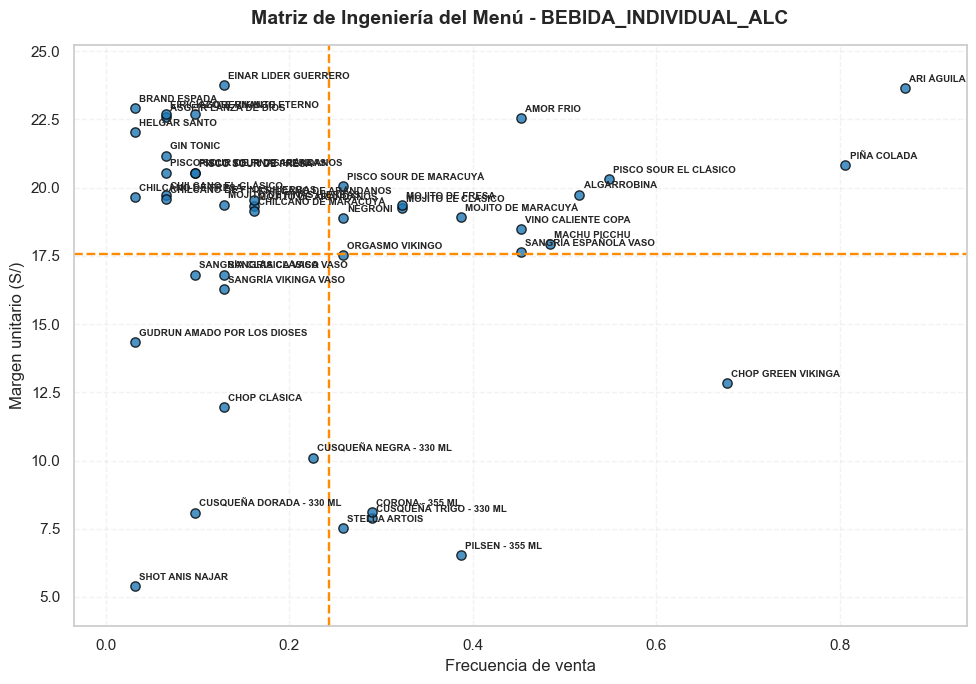

In [12]:
plot_menu_engineering(df_tienda, 'BEBIDA_INDIVIDUAL_ALC')

En el caso de las **bebidas alcohólicas individuales**, la distribución es más compacta y estable. La mayoría de productos se ubica alrededor de un **margen medio consistente**, con rotación uniforme y sin cargas operativas complejas.

Existen bebidas con buen rendimiento, como **Piña Colada** y **Pisco Sour Clásico**, ubicadas en cuadrantes de alta frecuencia y buen margen, funcionando como “atractores” del consumo complementario. Asimismo, los productos de bajo desempeño no generan un impacto operativo significativo ni representan un costo elevado por mantenerse en carta.

En conjunto, esta categoría **no requiere una reducción agresiva**, sino ajustes focalizados en precios, upselling y visibilidad en carta, manteniéndose como soporte rentable y estable para la operación.

## 3.6 Conclusiónes EDA
El análisis exploratorio revela patrones importantes en el comportamiento del portafolio: categorías con exceso de productos, algunos ítems claramente “estrella” y otros con un aporte muy reducido. Sin embargo, **las decisiones basadas solo en frecuencia de venta y margen unitario resultan insuficientes** para guiar una optimización real de la carta.

Existen factores operativos que impactan directamente la rentabilidad —como la **complejidad de preparación, la cantidad de insumos requeridos, la rotación diaria y los costos indirectos asociados**— que no pueden evaluarse completamente mediante gráficos univariados o bivariados.

Además, se observan casos donde productos con buen margen unitario presentan baja rotación, o productos con alta popularidad implican una carga operativa considerable. Esto evidencia que **no es posible determinar con precisión qué productos mantener, mejorar o retirar únicamente con la intuición o métricas tradicionales**.

En conjunto, el EDA ofrece señales valiosas, pero **no basta para priorizar decisiones sobre un portafolio tan amplio y heterogéneo**, lo que motivará un análisis más profundo que integre simultáneamente todas las dimensiones y reglas relevantes del negocio.

# 4. Planteamiento de la Estrategia

El análisis exploratorio inicial mostró que el portafolio presenta una alta heterogeneidad: coexisten productos muy populares y rentables con otros de bajo margen, baja rotación y elevada complejidad operativa.
Dado este comportamiento no lineal, se requiere un método capaz de identificar grupos reales sin asumir formas esféricas ni un número fijo de clusters.
Por ello, la estrategia se centrará en **clasificar únicamente las dos categorías con mayor volumen e impacto operativo**:

- **PLATO_FONDO_INDIVIDUAL**
- **BEBIDA_INDIVIDUAL_ALC**

Estas categorías concentran la mayor carga operativa, uso de insumos y aporte económico, por lo que optimizarlas influye directamente en la rentabilidad del negocio.

---
## 4.1 Roadmap general de la estrategia

| **Paso** | **Descripción** | **Resultado esperado** |
|---------|------------------|-------------------------|
| **0. Selección del target (focalización del análisis)** | Identificar y aislar las dos categorías con mayor volumen, complejidad y relevancia operativa: **PLATO_FONDO_INDIVIDUAL** y **BEBIDA_INDIVIDUAL_ALC**. | Enfoque del modelamiento en los grupos donde la optimización tiene el mayor impacto real. |
| **1. Construcción de variables operativas combinadas** | Integrar margen, frecuencia de venta, costos, insumos y nuevas métricas derivadas que capturen eficiencia, complejidad y aporte económico. | Representación multidimensional más completa y fiel del desempeño operativo y económico del producto. |
| **2. Reducción de dimensionalidad (PCA + UMAP)** | Utilizar PCA para patrones lineales y UMAP para estructuras no lineales, reduciendo ruido y facilitando visualización. | Espacios 2D claros donde emergen agrupaciones naturales del portafolio. |
| **3. Fase 1: DBSCAN (clusters principales)** | Detectar grupos naturales basados en densidad, sin necesidad de fijar K, manejando outliers y relaciones irregulares. | Clasificación inicial en: productos fuertes, estables, débiles y atípicos. |
| **4. Fase 2: Clustering jerárquico (subgrupo débil)** | Aplicar clustering jerárquico al cluster débil, con cortes silhouette adaptativos para separar grupos internos. | Identificación fina: candidatos a retiro, optimizables y productos de alta complejidad operativa. |
| **5. Visualización y reporte final** | Representar clusters en PCA/UMAP y entregar recomendaciones operativas basadas en evidencia. | Conjunto claro de acciones: retirar, optimizar, potenciar o revisar productos. |

---

---

## 4.2 Justificación de la metodología

El EDA mostró que las relaciones entre las variables del portafolio son heterogéneas:

- Correlaciones **moderadas** entre costo y margen.
- Correlaciones **bajas** entre frecuencia de venta y margen.
- Dependencias **no lineales** entre insumos, complejidad operativa y desempeño económico.
- Existencia de **outliers estructurales** (productos muy caros, raros o poco vendidos).

Esto justifica el uso de una metodología multivariada que integre componentes lineales, no lineales y basados en densidad.

---

## 1. Creación de variables operativas combinadas

La integración de margen, rotación, costos y cantidad de insumos permitirá capturar:

- Carga operativa real
- Eficiencia económica integrada
- Complejidad de preparación
- Aporte al margen diario

Una visión más rica que el análisis tradicional univariado.

---

## 2. Reducción de dimensionalidad: PCA + UMAP

### PCA
Utilizado porque:

- Identifica direcciones lineales de mayor variabilidad.
- Reduce redundancias entre variables correlacionadas.
- Brinda interpretabilidad global del comportamiento del portafolio.

### UMAP
Elegido porque:

- Capta relaciones **no lineales** entre rotación, costo y complejidad.
- Preserva estructura local y global.
- Genera representaciones visuales que revelan clusters naturales no detectados por PCA.

---

## 3. DBSCAN como método principal de clustering

Se seleccionó DBSCAN porque:

- No requiere elegir un número K.
- Detecta grupos reales según densidad.
- Maneja outliers identificando productos atípicos.
- Funciona adecuadamente en espacios no lineales como UMAP.

Los clusters obtenidos permiten separar productos fuertes, medios, débiles y ruidosos.

---

## 4. Subclasificación mediante clustering jerárquico

Aplicado exclusivamente al **cluster débil**, ya que es ahí donde la empresa necesita tomar decisiones:

- Facilita interpretar la estructura interna del grupo.
- Permite cortes dinámicos mediante **silhouette adaptativo**.
- Distingue entre productos a retirar, optimizar o revisar operativamente.

---

En conjunto, esta metodología combina análisis lineal, no lineal, densidad y jerarquía, logrando una segmentación profunda, coherente y accionable del portafolio de productos de la empresa.

## Referencias

- **Principios de Ingeniería de Menú**
  https://opentextbc.ca/basickitchenandfoodservicemanagement/chapter/describe-the-principles-of-menu-engineering/
